In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")


In [26]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model = "gemini-2.0-flash", temperature=0, google_api_key = GOOGLE_API_KEY)

In [27]:
def multiply(a,b):
    ''' Multiply two numbers
    Args:
    a: first int
    b: second int
    '''
    return a*b

def divide(a,b):
    ''' Divide two numbers
    a: first int
    b: second int
    '''
    return a//b

def add(a,b):
    ''' Add two numbers
    a: first int
    b: second int
    '''
    return a+b

llm_with_tools = llm.bind_tools([multiply, add, divide])

In [60]:
from langchain_core.messages import SystemMessage, AnyMessage, HumanMessage
from langgraph.graph import MessagesState
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs")

def assistant(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke([sys_msg] + messages)
    return {"messages": messages + [response]}

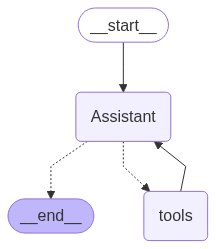

In [61]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)
builder.add_node("Assistant", assistant)
builder.add_edge(START, "Assistant")
builder.add_node("tools", ToolNode([add, multiply, divide]))
builder.add_conditional_edges("Assistant", tools_condition)
builder.add_edge("tools", "Assistant")
react_graph = builder.compile()
react_graph

## Adding memory to different calls of the graph

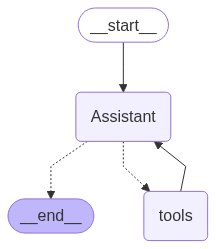

In [62]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer = memory)
react_graph_memory

## Graph has been compiled, we need to use one thread id for the execution. 

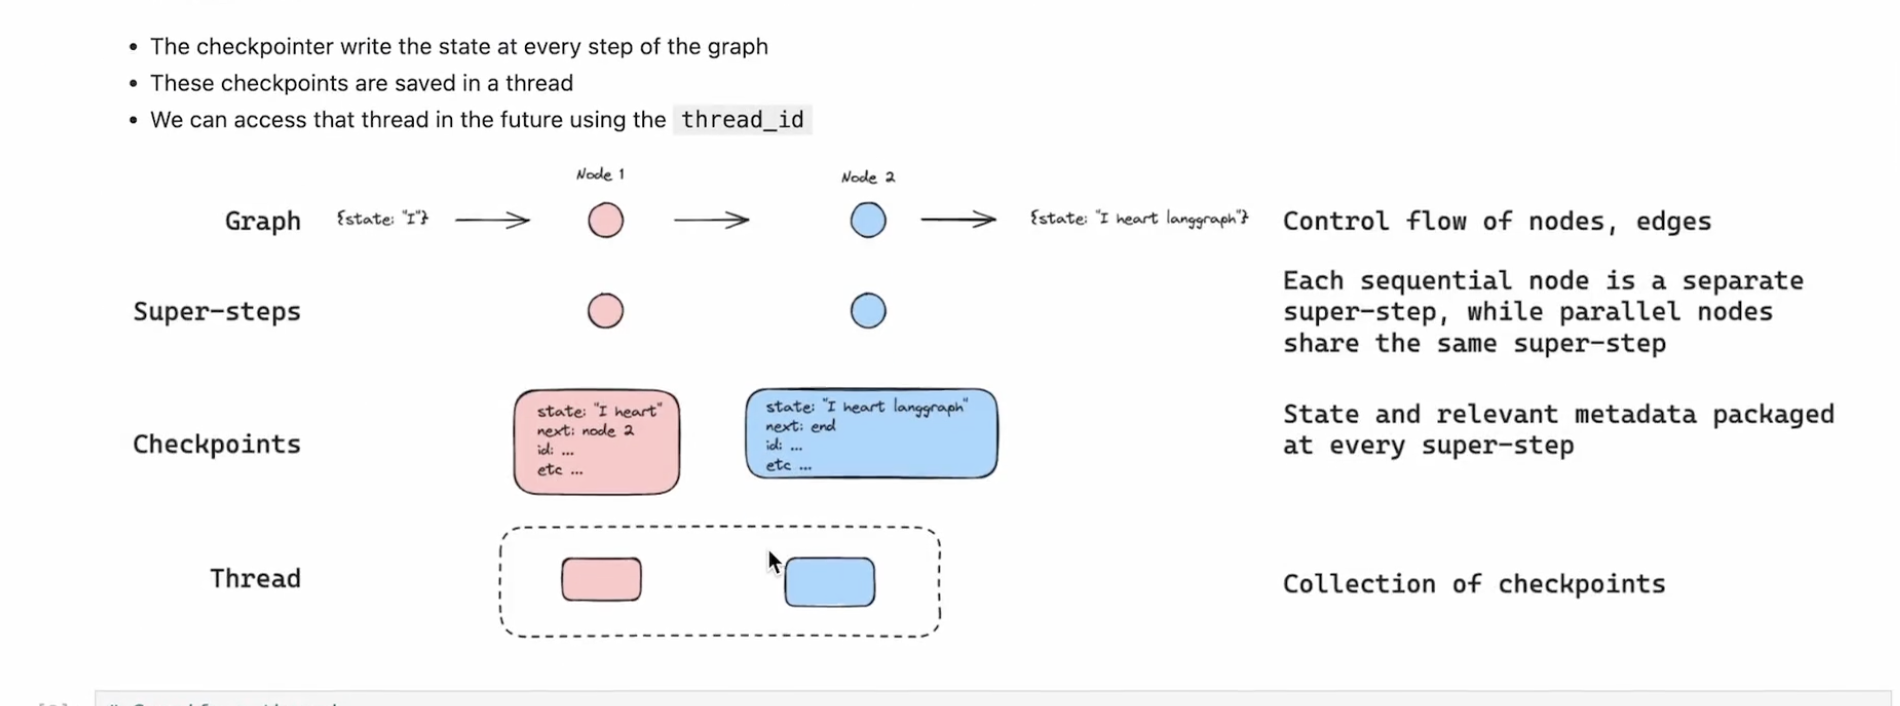

In [63]:
config = {'configurable': {'thread_id': 1}}
messages = [HumanMessage(content = "Add 3 and 4")]

messages = react_graph_memory.invoke({'messages': messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (48e9b958-48f3-4658-adc5-0beed81074e1)
 Call ID: 48e9b958-48f3-4658-adc5-0beed81074e1
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7.0
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [64]:
messages = [HumanMessage(content = "Multiply that by 2")]

messages = react_graph_memory.invoke({'messages': messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (48e9b958-48f3-4658-adc5-0beed81074e1)
 Call ID: 48e9b958-48f3-4658-adc5-0beed81074e1
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7.0
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (f8db247c-3261-4104-9c98-44f0666552fd)
 Call ID: f8db247c-3261-4104-9c98-44f0666552fd
  Args:
    a: 7.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

14.0
================================== Ai Message ===================